In [1]:
import pandas as pd
from bs4 import BeautifulSoup
from collections import Counter
from collections.abc import Callable
from typing import Any
from typing import Iterable
import nltk
import re
import get_cref
from collections import defaultdict
from constants import *

### Get word levels first (turns out it wasn't needed)

In [2]:
cref: defaultdict = defaultdict(set)
with open(get_cref.SAVE_FILENAME, 'r') as f:
    for word, word_class in map(lambda line: line.strip().split(get_cref.SEPARATOR), f.readlines()):
        cref[word].add(word_class)

In [3]:
for x in cref:
    if len(cref[x]) == 0:
        print(x)

# Data preprocessing

### Reading questions

In [4]:
def read_questions() -> pd.DataFrame:
    return pd.read_json(QUESTIONS_PATH)

In [5]:
questions: pd.DataFrame = read_questions()[COLUMNS]

In [6]:
questions.head()

,stem,stimulus,rationale,answerOptions,correct_answer
0,<p>Which choice most logically completes the t...,<p>Marta Coll and colleagues&rsquo; 2010 Medit...,<p>Choice B is the best answer because it pres...,[{'id': '21140db9-ae9f-4478-be55-2511c86ebdd0'...,[B]
1,<p>Which quotation from a researcher would bes...,<p>Fish whose DNA has been modified to include...,<p>Choice D is the best answer because this qu...,[{'id': '94691976-fdcd-44b2-8537-b0cfb45c63e3'...,[D]
2,<p>Which choice best states the main idea of t...,<p>Many literary theorists distinguish between...,<p>Choice A is the best answer because it most...,[{'id': '939b7c52-2208-4eb5-99c2-0bafe31083e4'...,[A]
3,<p>Which choice most effectively uses data fro...,"<p><figure class=""table""><table class=""gdr""><c...",<p>Choice C is the best answer because it most...,[{'id': '20d142fd-4df1-4f6f-93c4-53a7a033cb44'...,[C]
4,<p>Which choice most logically completes the t...,<p>The practice of logging (cutting down trees...,<p>Choice A is the best answer because it most...,[{'id': 'c98af2b4-0ca7-41a0-a23a-70bffce88cae'...,[A]


### Functions to transfrom correct answer from a list of characters to a number

In [7]:
def is_always_one(s: pd.Series) -> bool:
    return s.map(lambda x: len(x) == 1).all()


def unpack_correct(df_: pd.DataFrame) -> None:
    assert is_always_one(df_[CORRECT]), "Can't unpack! There are multiple correct answers!"
    df_[CORRECT] = df_[CORRECT].map(lambda x: x[0])


def transform_answer_to_number(df_: pd.DataFrame, max_char: str) -> None:
    mapping = {
        c: ord(c) - ord('A')
        for c in (
            chr(i) for i in range(ord('A'), ord(max_char) + 1)
        )
    }
    df_[CORRECT] = df_[CORRECT].map(mapping)


def get_max_char(df_: pd.DataFrame) -> str:
    return chr(df_[CORRECT].map(lambda c: ord(c)).max())


def transform_correct_answer(df_: pd.DataFrame) -> None:
    if pd.api.types.is_numeric_dtype(df_[CORRECT]):
        return  # our job MAY be done already or the data is incorrect
    unpack_correct(df_)
    transform_answer_to_number(df_, get_max_char(df_))

### Functions to get all the html tags used in stimulus

In [8]:
def get_all_tags():
    result = set()
    for el in questions[STIMULUS]:
        result = result.union({tag.name for tag in BeautifulSoup(el, "lxml").find_all()})
    return result


print(get_all_tags())

{'defs', 'caption', 'th', 'line', 'html', 'svg', 'rect', 'polygon', 'figure', 'em', 'table', 'body', 'li', 'span', 'u', 'marker', 'circle', 'strong', 'ul', 'thead', 'sub', 'g', 'p', 'tr', 'text', 'td', 'sup', 'div', 'br', 'pattern', 'path', 'tbody', 'blockquote'}


### Hardcoded text tags

In [9]:
POSSIBLE_TEXT_TAGS = [
    "p",
    "h1", "h2", "h3", "h4", "h5", "h6",
    "li",
    "blockquote",
    "caption",
    "span",
    "strong",
    "em",
    "u",
]

### Functions to extract text from html responses

In [10]:
def get_all_text(html_text: str) -> list[str]:
    return [
        text.strip(' ')  # want to leave the line breaks
        for text in BeautifulSoup(html_text, 'lxml').strings
        if text.strip() and (text.parent.name in POSSIBLE_TEXT_TAGS)
    ]


def parse_html_text_cell(
        html_text: None | str,
        delimiter: str = ' '
) -> None | str:
    if html_text is None:
        return html_text
    texts = get_all_text(html_text)
    return delimiter.join(texts)


def transform_html_text_column(df_: pd.DataFrame, column: str, delimiter: str = ' '):
    df_[column] = df_[column].map(lambda c: parse_html_text_cell(c, delimiter))

### Functions to transform answers from list of objects into a list of strings  

In [11]:
def parse_answer_object_list(answers: list[dict]) -> list[str]:
    return list(map(lambda answer: parse_html_text_cell(answer['content']), answers))


def transform_answers(df_: pd.DataFrame):
    if df_[ANSWERS].map(lambda lst: all(map(lambda x: isinstance(x, dict), lst))).all():
        df_[ANSWERS] = df_[ANSWERS].map(lambda lst: parse_answer_object_list(lst))

### Transforming all the columns into a more appropriate format

In [12]:
transform_html_text_column(questions, STEM)
transform_html_text_column(questions, STIMULUS)
transform_html_text_column(questions, RATIONALE)
transform_answers(questions)
transform_correct_answer(questions)

In [13]:
questions.head()

,stem,stimulus,rationale,answerOptions,correct_answer
0,Which choice most logically completes the text?,Marta Coll and colleagues’ 2010 Mediterranean ...,Choice B is the best answer because it present...,[Coll and colleagues reported a much higher nu...,1
1,Which quotation from a researcher would best s...,Fish whose DNA has been modified to include ge...,Choice D is the best answer because this quota...,[“In one site in the wild where transgenic fis...,3
2,Which choice best states the main idea of the ...,Many literary theorists distinguish between fa...,Choice A is the best answer because it most ac...,[Literary theorist Mikhail Bakhtin argued that...,0
3,Which choice most effectively uses data from t...,Sample of Food Items from Gemini Mission Menus...,Choice C is the best answer because it most ef...,"[shrimp cocktail for meal B., hot cocoa for me...",2
4,Which choice most logically completes the text?,The practice of logging (cutting down trees fo...,Choice A is the best answer because it most lo...,[logging may be useful for maintaining healthy...,0


# Word counting

### Download word datasets to ignore words of little value to us

In [14]:
#Download and import list of stopwords
nltk.download("stopwords")
nltk.download("punkt_tab")
from nltk.corpus import stopwords

#list of stopwords
stopwords_set: set = set(stopwords.words("english"))
stopwords_set.add('n’t')
stopwords_set.add('blank')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dannypa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/dannypa/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Creating a model to tokenize sentences and lemmatize words

In [15]:
from wordfreq import word_frequency
import spacy

nlp = spacy.load("en_core_web_sm")

### A dataclass to store information about each lemma; includes occurence count and all the variations of this lemma we've encountered.

In [16]:
from dataclasses import dataclass, field


@dataclass
class LemmaData:
    count: int = 0
    versions: set = field(default_factory=set)

    def average_frequency(self) -> float:
        return sum(map(lambda w: word_frequency(w, 'en'), self.versions)) / len(self.versions)

### Functions to check if a word is "meaningful" to us (heuristics)

In [17]:

FREQ_CUTOFF = 1e-5
DATE_PATTERN = re.compile(r"\d{4}(s?)")
def is_date(word: str):
    return DATE_PATTERN.fullmatch(word) is not None

def is_rare_word(word: str):
    return 0 < word_frequency(word, 'en') <= FREQ_CUTOFF

def is_meaningful_word(word: str):
    if is_date(word) or (word in stopwords_set) or len(word) <= 1:
        return False # not a word or a stopword or a punctuation sign
    return is_rare_word(word)

### Functions to count words in all of the responses

In [18]:
def count_words_series(column: pd.Series, counter: Counter, parseCell: Callable[[Any, Counter], None]):
    for cell in column.values:
        parseCell(cell, counter)

def count_words_string(text: str, counter: dict):
    for w in nlp(text.lower()):
        lemma = w.lemma_
        if is_meaningful_word(w.text):
            # print("abs")
            counter[lemma].versions.add(w.text)
            counter[lemma].count += 1

def count_words_string_list(lst: list[str], counter: defaultdict):
    for s in lst:
        count_words_string(s, counter)

def count_words_df(df_: pd.DataFrame, string_columns: Iterable[str], string_list_columns: Iterable[str]) -> defaultdict:
    result = defaultdict(LemmaData)
    for column in string_columns:
        count_words_series(df_[column], result, count_words_string)
    for column in string_list_columns:
        count_words_series(df_[column], result, count_words_string_list)
    return result

In [19]:
word_count_dict = count_words_df(questions, filter(lambda s: s != RATIONALE, STRING_COLUMNS), STRING_LIST_COLUMNS.copy())

### Transforming the words into a list sorted by the number of occurences

In [20]:
word_count = list(word_count_dict.items())
word_count.sort(key=lambda cnt: -cnt[1].count)

In [21]:
word_count[:10]

[('complete', LemmaData(count=661, versions={'completes'})),
 ('convention', LemmaData(count=294, versions={'conventions'})),
 ('conform', LemmaData(count=290, versions={'conform', 'conforms'})),
 ('research', LemmaData(count=152, versions={'researching', 'researched'})),
 ('logically', LemmaData(count=94, versions={'logically'})),
 ('emphasize',
  LemmaData(count=83, versions={'emphasized', 'emphasizing', 'emphasizes', 'emphasize'})),
 ('historian', LemmaData(count=74, versions={'historian', 'historians'})),
 ('illustrate',
  LemmaData(count=67, versions={'illustrating', 'illustrates', 'illustrate'})),
 ('fossil', LemmaData(count=66, versions={'fossil', 'fossils'})),
 ('analyze',
  LemmaData(count=65, versions={'analyze', 'analyzing', 'analyzes', 'analyzed'}))]

### A list that for each lemma stores its number of occurences, average frequency in english language and its CREF level (if known) 

In [22]:
lemma_info = [
    (lemma, lemma_info.count, lemma_info.average_frequency(), None if lemma not in cref else cref[lemma])
    for lemma, lemma_info in word_count
]

len(lemma_info)

8115

In [23]:
lemma_info[:10]

[('complete', 661, 3.31e-06, {'A2', 'B1'}),
 ('convention', 294, 6.03e-06, {'C1'}),
 ('conform', 290, 2.0255e-06, None),
 ('research', 152, 3.9499999999999995e-06, {'B1', 'B2'}),
 ('logically', 94, 2.69e-06, {'C2'}),
 ('emphasize', 83, 3.835e-06, {'B2'}),
 ('historian', 74, 7.275000000000001e-06, {'C1'}),
 ('illustrate', 67, 3.83e-06, {'B2', 'C1'}),
 ('fossil', 66, 6.619999999999999e-06, None),
 ('analyze', 65, 5.385e-06, None)]

# Visualizing results with a word cloud

In [24]:
lemma_dict = {word: freq for word, freq, _, _ in lemma_info}

In [25]:
from wordcloud import WordCloud

wc = WordCloud(width=1000, height=800, max_words=100)\
    .generate_from_frequencies(lemma_dict)\
    .to_file(f"data/result{FREQ_CUTOFF}.png")

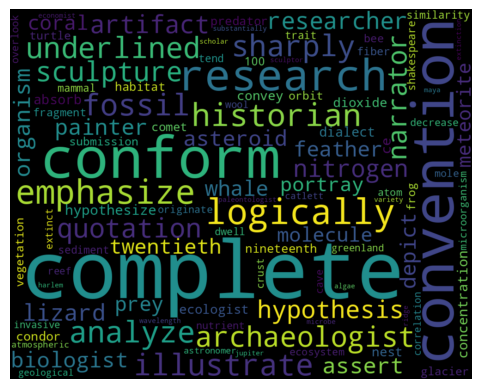

In [26]:
import matplotlib.pyplot as plt

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show() # see png for better resolution